# Treatability scores

__WORK IN PROGRESS__ - reinventing the wheel?

Get SHAP values, combine them to get a score for each patient. Measures how easily treatable they are.

## Notebook setup:

In [11]:
import pandas as pd
import numpy as np
import pickle
from dataclasses import dataclass
import yaml

import matplotlib.pyplot as plt

import stroke_utilities.process_data as process_data

In [18]:


# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import machine learning methods
from xgboost import XGBClassifier

from os.path import exists

import shap

from scipy import stats

import os
import pickle
import json

# .floor and .ceil
import math

# So can take deep copy
import copy



## Set up paths and filenames

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities/output/'
    model_folder = './stroke_utilities/models'

paths = Paths()

In [27]:
# Set up strings (describing the model) to use in filenames
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '04'

## Import SHAP explainer

In [6]:
with open(f'{paths.model_folder}/shap_explainer.p', 'rb') as fp:
    explainer = pickle.load(fp)

## Load data

Import the data from file:

In [7]:
# Load data
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

## Process data

Restrict the data to the following ten features, plus the "thrombolysis" feature.

In [8]:
# Put data into the format for model
features_to_model = [
    'stroke_team_id',
    'stroke_severity',
    'prior_disability',
    'age',
    'infarction',
    'onset_to_arrival_time',
    'precise_onset_known',
    'onset_during_sleep',
    'arrival_to_scan_time',
    'afib_anticoagulant',
    # 'year',    
    'thrombolysis'
]

In [9]:
test = test[features_to_model]

If the year of admission to stroke team is still in the data, restrict it to the following range.

Currently this process does nothing because we have already removed "year" from the data.

In [12]:
test = process_data.restrict_data_to_range(test, 2016, 2018, 'year')

Split the data. X contains the features for the model to use to predict use of thrombolysis, and y contains whether thrombolysis was used in the real data.

In [13]:
X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')

Check the list of features currently included in the X data:

In [14]:
features = list(X_test)

features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

For the XGBoost model, we need to change the single "stroke team ID" column to many individual team columns. For 119 separate teams, we will create 119 new columns. Each column may contain either 1 (meaning "yes") where a patient attended that stroke team, or 0 (meaning "no") where the patient did not attend that stroke team.

In [15]:
X_test = process_data.one_hot_encode_column(
    X_test, 'stroke_team_id', prefix='team')

Check that the "stroke_team_id" column has gone and that there are now many "team_" columns.

In [21]:
# Get features
feature_names_ohe = list(X_test)

# Print the first several...
print(feature_names_ohe[:15])
# ... and last few feature names:
print(feature_names_ohe[-3:])
# The remaining features are all "team_X" for increasing X.

['stroke_severity', 'prior_disability', 'age', 'infarction', 'onset_to_arrival_time', 'precise_onset_known', 'onset_during_sleep', 'arrival_to_scan_time', 'afib_anticoagulant', 'team_1', 'team_2', 'team_3', 'team_4', 'team_5', 'team_6']
['team_117', 'team_118', 'team_119']


## Create SHAP values for the test data: log-odds units

Pass the X_test data to the explainer object:

In [17]:
shap_values_extended = explainer(X_test)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## Setup for box plots

The code is copied from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb

In [22]:
# Get SHAP values
shap_values = shap_values_extended.values

# Calculate mean SHAP value for each feature (across all instances)
df_shap_values_mean = pd.DataFrame(index=feature_names_ohe)

features_shap_ranked = list(df_shap_values_mean.head(9).index)


df_shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
df_shap_values_mean['abs_mean_shap'] = np.abs(df_shap_values_mean['mean_shap'])
df_shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df_shap_values_mean['rank'] = df_shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values
df_shap_values_mean.sort_values('rank', inplace=True, ascending=True)
df_shap_values_mean.head(10)


,mean_shap,abs_mean_shap,mean_abs_shap,rank
infarction,-1.103923,1.103923,1.711107,1.0
stroke_severity,-0.102933,0.102933,0.927903,2.0
precise_onset_known,-0.035485,0.035485,0.502079,3.0
arrival_to_scan_time,-0.078830,0.078830,0.432781,4.0
prior_disability,0.000895,0.000895,0.395190,5.0
afib_anticoagulant,-0.049736,0.049736,0.393511,6.0
onset_to_arrival_time,-0.005894,0.005894,0.196703,7.0
age,-0.007623,0.007623,0.166250,8.0
onset_during_sleep,-0.009321,0.009321,0.092064,9.0
team_14,-0.002652,0.002652,0.030783,10.0


In [23]:
features_shap_ranked = list(df_shap_values_mean.head(9).index)

## Create box plots

The code is copied from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb with minor changes to collect the box plot values.

In [25]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)


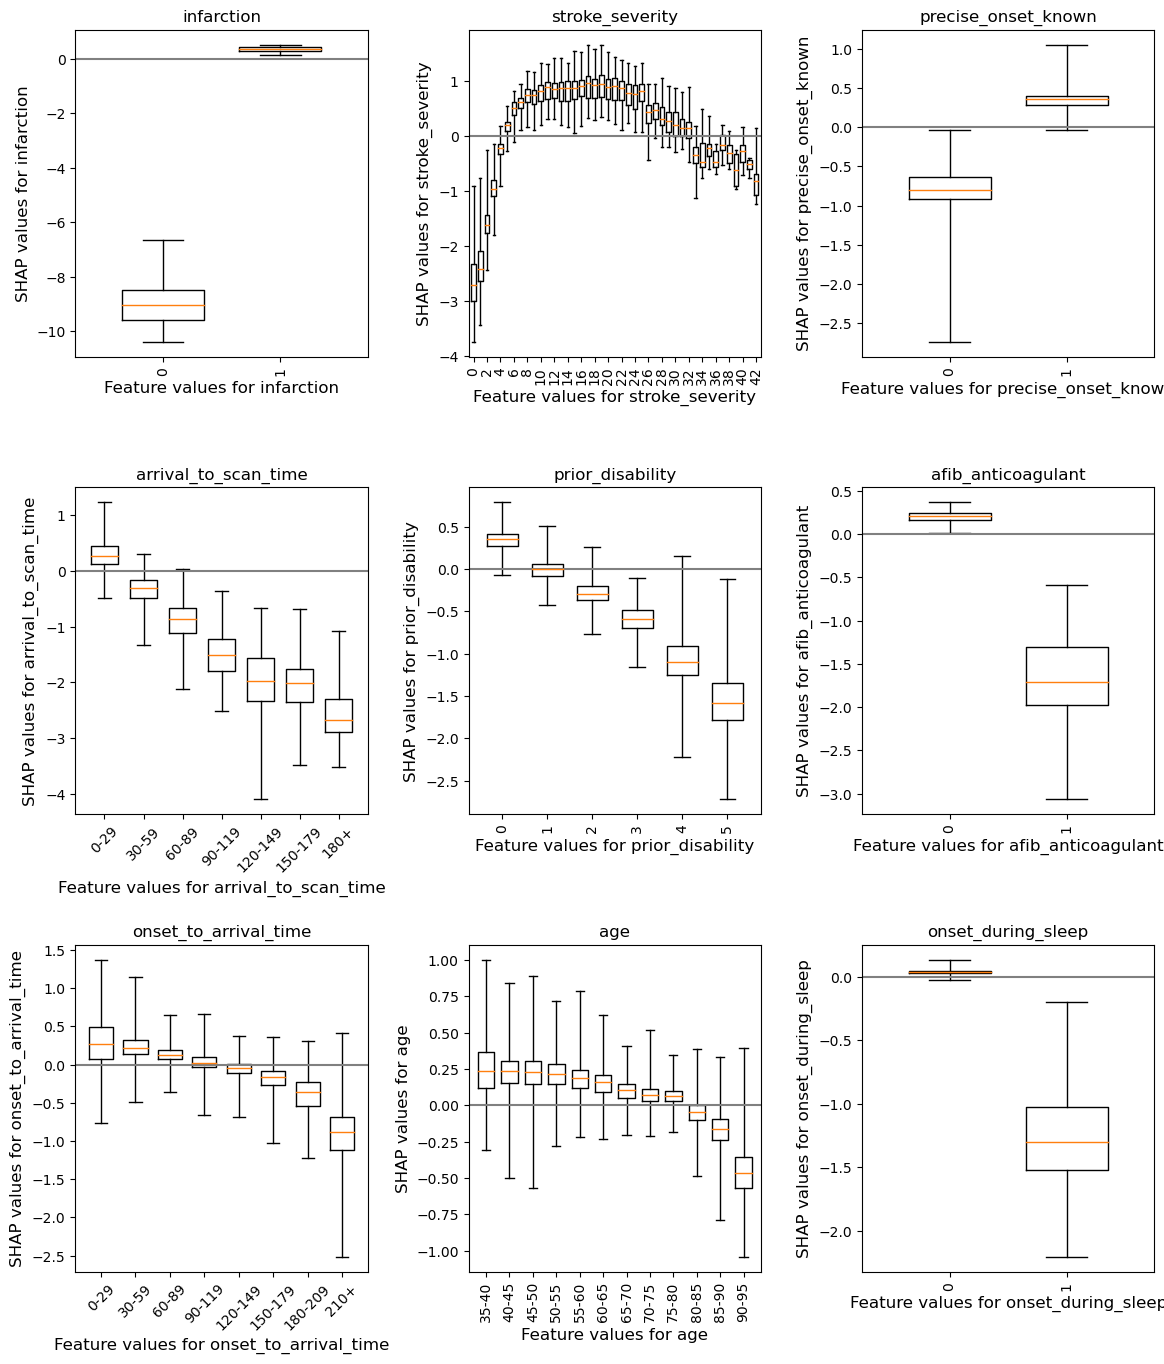

In [53]:
# Feature Age needs special consideration. It needs the x ticks to be created,
# as the other features with over 50 unique values, but age is already grouped 
# for the model (into 5yr groups) and so is treated as the other type.

# Create figure
fig = plt.figure(figsize=(12,14), constrained_layout=True)
# A subplot showing violin plot for each feature.
# First prepare the fature data for the violin plot: if feature has more than 
# 50 unique values then assume it needs to be binned (a violin for each bin)

# Determine number of rows of subplots by rounding up
nrows = math.ceil(len(features_shap_ranked)/4)

# Through each feature
boxplot_dicts = {}
bin_dicts = {}
category_dicts = {}
for n, feat in enumerate(features_shap_ranked):    
    
    # Get data adn SHAP values
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # If feature has more that 50 unique values, then assume it needs to be 
    # binned (otherwise assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(11, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list = [f'{i*step}-{((i+1)*step-1)}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                              right=False)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        # Age needs to keep its decimal value (midpoint between 5 yrs)
        category_list = np.unique(feature_data)
        if feat != "age":
            category_list = [int(i) for i in category_list]

        # Add this for return:
        bin_list = category_list

    # create a list, each entry contains the corresponsing SHAP value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # # Output descriptive text to use in the paper to describe the differences a 
    # # feature value had on the likelihood of receiving thromboylsis.
    # if feat == "infarction":
    #     range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Stroke type: The SHAP values for stroke type show that the \n"
    #           f"model effectively eliminated any probability of receiving \n"
    #           f"thrombolysis for non-ischaemic (haemorrhagic) stroke. The \n"
    #           f"odds of receiving thrombolysis fell about {round(odds,2)} \n"
    #           f"fold.\n")    
    # if feat == "arrival_to_scan_time":
    #     range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[3])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Arrival-to-scan time: The odds of receiving thrombolysis reduced by \n"
    #     f"about {round(odds,2)} (20) fold over the first 120 minutes of arrival to scan time.\n")    
    # if feat == "stroke_severity":
    #     range_shap_log_odds = np.mean(shap_per_category[19]) - np.mean(shap_per_category[0])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest\n"
    #       f" at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again \n"
    #       f"with higher stroke severity (NIHSS above 25). The difference between \n"
    #       f"minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving \n"
    #       f"thrombolysis was {round(odds,2)} (30-35) fold.\n")
    # if feat == "precise_onset_known":
    #     range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Stroke onset time type (precise vs. estimated): The odds of receiving \n"
    #       f"thrombolysis were about {round(odds,2)} (3) fold greater for precise onset time than \n"
    #       f"estimated onset time.\n")
    # if feat == "prior_disability":
    #     range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[5])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Disability level (mRS) before stroke: The odds of receiving \n"
    #     f"thrombolysis fell about {round(odds,2)} (5) fold between mRS 0 and 5.\n")
    # if feat == "afib_anticoagulant":
    #     range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Use of AF anticoagulants: The odds of receiving thrombolysis were about\n"
    #     f" {round(odds,2)} fold greater for no use.\n")
    # if feat == "onset_to_arrival_time":
    #     range_shap_log_odds = np.mean(shap_per_category[4]) - np.mean(shap_per_category[7])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Onset-to-arrival time: The odds of receiving thrombolysis were similar \n"
    #     f"below 120 minutes, then fell about {round(odds,2)} fold between 120 and above.\n")
    # if feat == "age":
    #     range_shap_log_odds = np.mean(shap_per_category[13]) - np.mean(shap_per_category[17])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Age: The odds of receiving thrombolysis were similar below 80 years \n"
    #     f"old, then fell about {round(odds,2)} fold between 80 and 120 years old.\n")
    # if feat == "onset_during_sleep":
    #     range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
    #     odds = math.exp(range_shap_log_odds)
    #     print(f"Onset during sleep: The odds of receiving thrombolysis were about \n"
    #     f"{round(odds,2)} fold lower for onset during sleep.\n")

    if feat == "age":
        # create text of x ticks
        category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for i in category_list]

        # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
        #   the other ages). To accommodate this, if last age category is "110"
        #   then overwrite the label with the correct band (100-120), and not
        #   107-112 as the above code would create.
        if category_list[-1] == '107-112':
            category_list[-1] = '100-120'
            
    # create violin plot
    ax = fig.add_subplot(nrows,3,n+1)
    
    boxplot_dict = ax.boxplot(shap_per_category, whis=99999, widths=0.7)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == "stroke_severity":
        ax.set_xticks(np.arange(1, len(category_list)+1, 2))
        ax.set_xticklabels(category_list[0::2])   
    
    # Add title
    ax.set_title(feat)

    boxplot_dicts[feat] = boxplot_dict
    bin_dicts[feat] = bin_list
    category_dicts[feat] = category_list
    
plt.tight_layout(pad=2)
    
fig.savefig(f'stroke_utilities/output/{notebook}_{model_text}_thrombolysis_shap_boxplot_all_'
            f'features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()



## Extract all of the median values from these box plots:

In [51]:
median_dicts = {}
for key in boxplot_dicts.keys():
    median_lines = boxplot_dicts[key]['medians']
    meds = []
    for i, line in enumerate(median_lines):
        med = line.get_ydata()[0]
        meds.append(med)
    median_dicts[key] = meds

In [52]:
median_dicts

{'infarction': [-9.035469055175781, 0.35362885892391205],
 'stroke_severity': [-2.710878849029541,
  -2.4213027954101562,
  -1.6219841241836548,
  -0.9727904796600342,
  -0.22076712548732758,
  0.19476014375686646,
  0.5125318467617035,
  0.6200642287731171,
  0.7366729378700256,
  0.7530897259712219,
  0.8245656788349152,
  0.8824138343334198,
  0.8456839323043823,
  0.8628749847412109,
  0.8745764791965485,
  0.8700721263885498,
  0.9156414270401001,
  0.9633056819438934,
  0.9231318235397339,
  0.9478186964988708,
  0.897286593914032,
  0.9000478088855743,
  0.869219183921814,
  0.7769266963005066,
  0.7603655159473419,
  0.8172838091850281,
  0.44165046513080597,
  0.4691150188446045,
  0.30322712659835815,
  0.2681480050086975,
  0.19185565412044525,
  0.1486940234899521,
  0.14427077770233154,
  -0.34309151768684387,
  -0.4762231409549713,
  -0.2130834311246872,
  -0.4737842381000519,
  -0.16558630019426346,
  -0.313505619764328,
  -0.6127659678459167,
  -0.28023120015859604,
  -

## Find which bins each patient's data falls into

In [54]:
bin_dicts

{'infarction': [0, 1],
 'stroke_severity': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 'precise_onset_known': [0, 1],
 'arrival_to_scan_time': [0, 30, 60, 90, 120, 150, 180, 239.0],
 'prior_disability': [0, 1, 2, 3, 4, 5],
 'afib_anticoagulant': [0, 1],
 'onset_to_arrival_time': [0, 30, 60, 90, 120, 150, 180, 210, 254.0],
 'age': array([37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 72.5, 77.5, 82.5, 87.5,
        92.5]),
 'onset_during_sleep': [0, 1]}

In [55]:
category_dicts

{'infarction': [0, 1],
 'stroke_severity': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 'precise_onset_known': [0, 1],
 'arrival_to_scan_time': ['0-29',
  '30-59',
  '60-89',
  '90-119',
  '120-149',
  '150-179',
  '180+'],
 'prior_disability': [0, 1, 2, 3, 4, 5],
 'afib_anticoagulant': [0, 1],
 'onset_to_arrival_time': ['0-29',
  '30-59',
  '60-89',
  '90-119',
  '120-149',
  '150-179',
  '180-209',
  '210+'],
 'age': ['35-40',
  '40-45',
  '45-50',
  '50-55',
  '55-60',
  '60-65',
  '65-70',
  '70-75',
  '75-80',
  '80-85',
  '85-90',
  '90-95'],
 'onset_during_sleep': [0, 1]}

In [58]:
X_test.loc[0]

stroke_severity          10.0
prior_disability          2.0
age                      52.5
infarction                1.0
onset_to_arrival_time    70.0
                         ... 
team_115                  0.0
team_116                  0.0
team_117                  0.0
team_118                  0.0
team_119                  0.0
Name: 0, Length: 128, dtype: float64

In [61]:
val = X_test.loc[0]['stroke_severity']

In [62]:
bins = bin_dicts['stroke_severity']

In [63]:
x = np.digitize(val, bins)

In [64]:
x

11

In [68]:
for i in range(10):
    print(np.digitize(i, bins) - 1, bins[np.digitize(i, bins) - 1])

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


In [135]:
def collect_mean_shaps_for_patient(patient_data, bin_dicts, shap_dicts):
    shap_values_for_patient = {}
    for key in bin_dicts.keys():
        # Bins for this category:
        bins = bin_dicts[key]
        shaps = shap_dicts[key]
        # Value of this category for this patient:
        val = patient_data[key]
        # Bin this falls into:
        bin = np.digitize(val, bins) - 1
        # Sort out values outside the bin ranges:
        bin = 0 if bin < 0 else bin
        # For the time categories, the length of bins is one more
        # than the length of shaps. So make sure the value can
        # be accessed by using the last shaps bin, not the last 
        # bins bin.
        bin = -1 if bin == len(shaps) else bin
        # SHAP value for this bin:
        shap = shaps[bin]
        # Store in list:
        shap_values_for_patient[key] = shap
    return shap_values_for_patient

In [136]:
# Look up median shap values for all patients.
all_patient_shap_values = []
for p in range(len(X_test)):
    this_patient_data = X_test.loc[p]
    shap_values_for_patient = collect_mean_shaps_for_patient(this_patient_data, bin_dicts, median_dicts)
    # Convert dict to series:
    shap_values_for_patient = pd.Series(shap_values_for_patient.values(), shap_values_for_patient.keys())
    all_patient_shap_values.append(shap_values_for_patient)

In [137]:
len(all_patient_shap_values)

10000

In [141]:
# Convert all of those dictionaries to a single dataframe:
df_all_patient_shap_values = pd.DataFrame(all_patient_shap_values)

In [142]:
# Show the first five patients' values:
df_all_patient_shap_values.head(5).T

,0,1,2,3,4
infarction,0.353629,0.353629,0.353629,0.353629,-9.035469
stroke_severity,0.824566,0.870072,0.870072,-1.621984,-0.972790
precise_onset_known,0.362444,0.362444,0.362444,-0.794324,0.362444
arrival_to_scan_time,0.274701,0.274701,0.274701,-0.871277,0.274701
prior_disability,-0.289691,-0.005011,-1.094147,-0.005011,0.357452
afib_anticoagulant,0.205136,0.205136,0.205136,0.205136,-1.715489
onset_to_arrival_time,0.129469,0.215359,0.026407,0.129469,0.026407
age,0.213782,0.064194,-0.045162,0.073785,-0.164092
onset_during_sleep,0.036071,0.036071,0.036071,-1.303942,0.036071


In [149]:
# Sum the SHAP values for all patients
df_all_patient_shap_values['sum'] = df_all_patient_shap_values.sum(axis=1)

In [150]:
df_all_patient_shap_values.T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
infarction,0.353629,0.353629,0.353629,0.353629,-9.035469,0.353629,0.353629,0.353629,-9.035469,0.353629,...,0.353629,0.353629,0.353629,0.353629,0.353629,0.353629,0.353629,0.353629,0.353629,0.353629
stroke_severity,0.824566,0.870072,0.870072,-1.621984,-0.972790,-2.710879,-2.421303,0.947819,0.963306,-0.972790,...,-0.972790,-2.710879,0.194760,0.194760,0.736673,0.882414,0.303227,0.882414,0.303227,-0.972790
precise_onset_known,0.362444,0.362444,0.362444,-0.794324,0.362444,-0.794324,-0.794324,0.362444,0.362444,0.362444,...,-0.794324,0.362444,0.362444,0.362444,0.362444,0.362444,0.362444,0.362444,0.362444,0.362444
arrival_to_scan_time,0.274701,0.274701,0.274701,-0.871277,0.274701,-0.300209,-0.871277,0.274701,-0.300209,0.274701,...,0.274701,-0.300209,-0.300209,0.274701,0.274701,0.274701,0.274701,-0.300209,0.274701,0.274701
prior_disability,-0.289691,-0.005011,-1.094147,-0.005011,0.357452,0.357452,-0.005011,0.357452,-1.094147,0.357452,...,0.357452,-0.590308,0.357452,0.357452,0.357452,-0.590308,-0.289691,-0.590308,-0.590308,0.357452
afib_anticoagulant,0.205136,0.205136,0.205136,0.205136,-1.715489,0.205136,0.205136,0.205136,0.205136,0.205136,...,0.205136,-1.715489,0.205136,0.205136,0.205136,0.205136,0.205136,0.205136,-1.715489,0.205136
onset_to_arrival_time,0.129469,0.215359,0.026407,0.129469,0.026407,-0.355365,0.215359,-0.168328,0.026407,0.215359,...,0.129469,-0.168328,0.215359,-0.043380,0.129469,0.129469,0.263973,0.129469,0.129469,0.129469
age,0.213782,0.064194,-0.045162,0.073785,-0.164092,0.157556,0.106944,-0.045162,0.073785,0.157556,...,0.073785,-0.164092,0.185707,0.073785,0.237611,0.157556,-0.462922,-0.164092,-0.164092,0.073785
onset_during_sleep,0.036071,0.036071,0.036071,-1.303942,0.036071,0.036071,0.036071,0.036071,0.036071,0.036071,...,0.036071,0.036071,0.036071,0.036071,0.036071,0.036071,0.036071,0.036071,0.036071,0.036071
sum,2.110106,2.376594,0.989150,-3.834520,-10.830767,-3.050934,-3.174777,2.323761,-8.762677,0.989556,...,-0.336873,-4.897162,1.610348,1.814597,2.693184,1.811110,1.046568,0.914552,-1.010349,0.819895


In [153]:
mask_thrombolysed = y_test == 1
mask_not_thrombolysed = y_test != 1

In [156]:
df_all_patient_shap_values['sum'].min()

-16.323199653066695

In [192]:
df_all_patient_shap_values['sum'].max()

3.003403279930353

In [255]:
step = 0.5

hist_bins = step * np.arange(
    df_all_patient_shap_values['sum'].min() // step,
    2.0 + (df_all_patient_shap_values['sum'].max() // step),
    1
    ) - (0.5 * step)

print(hist_bins[:3])
print(min(hist_bins), max(hist_bins), len(hist_bins))

[-16.75 -16.25 -15.75]
-16.75 3.25 41


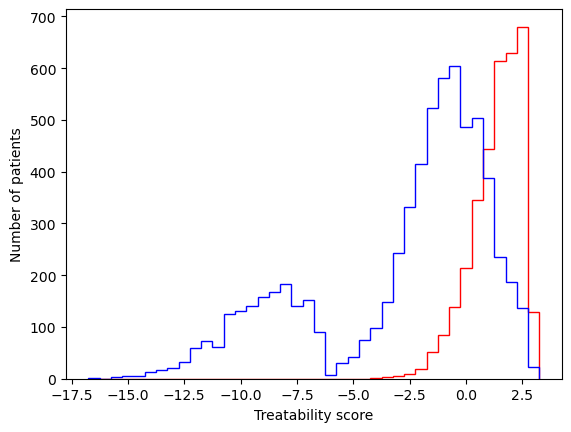

In [263]:
fig, ax = plt.subplots()

n_thrombolysed, bins, patches = ax.hist(
    df_all_patient_shap_values['sum'][mask_thrombolysed], 
    bins=hist_bins, color='r', histtype='step')
n_not_thrombolysed, bins, patches = ax.hist(
    df_all_patient_shap_values['sum'][mask_not_thrombolysed], 
    bins=hist_bins, color='b', histtype='step')

ax.set_xlabel('Treatability score')
ax.set_ylabel('Number of patients')
plt.show()

In [257]:
perc_thrombolysed = 100.0 * n_thrombolysed / (n_thrombolysed + n_not_thrombolysed)

In [258]:
hist_bins_mean = 0.5 * (hist_bins[:-1] +  hist_bins[1:])

In [265]:
def calculate_model_treatability(x, x_50perc):
    # Initial 50 + is for y-offset from centred on y=0 to y=50.
    # 50 * is for y-scale from range -1 to +1 to -50 to +50.
    # Within tanh, 0.5* is for making the slope less steep.
    # Within tanh, -x_50perc is for x-offset from centred on x=0 to x=x_50perc.
    y_model = 50.0 + 50.0 * np.tanh(0.5 * (x - x_50perc))
    return y_model

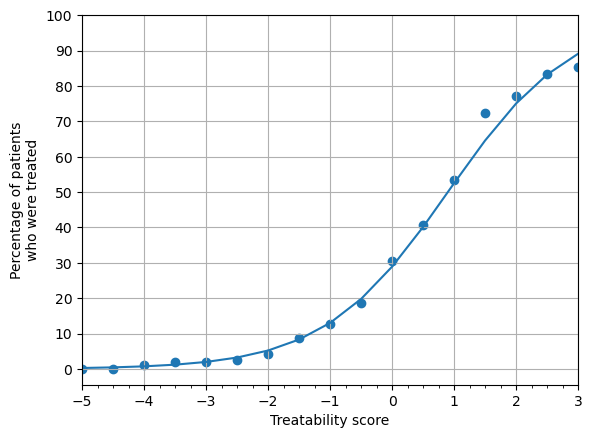

In [266]:
fig, ax = plt.subplots()

# Treatability score that gives 50% on the y-axis:
x_50perc = 0.9
# Define y-coordinates for a model line.
y_model = calculate_model_treatability(hist_bins_mean, x_50perc)
# Data:
ax.scatter(hist_bins_mean, perc_thrombolysed)
# Model:
ax.plot(hist_bins_mean, y_model)

# Graph setup:
ax.set_xlim(-5.0, 3.0)
ax.set_xticks(np.arange(-5.0, 3.0, 0.25), minor=True)
ax.set_yticks(np.arange(0.0, 100.1, 10))
ax.grid()

ax.set_xlabel('Treatability score')
ax.set_ylabel('Percentage of patients\nwho were treated')

plt.show()

In [261]:
# View data points from the chart:
pd.DataFrame([hist_bins_mean, perc_thrombolysed]).T

,0,1
0,-16.5,0.000000
1,-16.0,NaN
2,-15.5,0.000000
3,-15.0,0.000000
4,-14.5,0.000000
5,-14.0,0.000000
6,-13.5,0.000000
7,-13.0,0.000000
8,-12.5,0.000000
9,-12.0,0.000000


## Convert scores to chance of being picked by np.choice

In [267]:
all_model_treatability = calculate_model_treatability(df_all_patient_shap_values['sum'], x_50perc)

In [271]:
df_all_patient_shap_values['modelled_treatability_%'] = all_model_treatability

In [272]:
df_all_patient_shap_values.head(5).T

,0,1,2,3,4
infarction,0.353629,0.353629,0.353629,0.353629,-9.035469
stroke_severity,0.824566,0.870072,0.870072,-1.621984,-0.972790
precise_onset_known,0.362444,0.362444,0.362444,-0.794324,0.362444
arrival_to_scan_time,0.274701,0.274701,0.274701,-0.871277,0.274701
prior_disability,-0.289691,-0.005011,-1.094147,-0.005011,0.357452
afib_anticoagulant,0.205136,0.205136,0.205136,0.205136,-1.715489
onset_to_arrival_time,0.129469,0.215359,0.026407,0.129469,0.026407
age,0.213782,0.064194,-0.045162,0.073785,-0.164092
onset_during_sleep,0.036071,0.036071,0.036071,-1.303942,0.036071
sum,2.110106,2.376594,0.989150,-3.834520,-10.830767


Take the first 1000 patients in the list.

In [336]:
n_subset = 1000

In [337]:
df_treatability = pd.DataFrame()
df_treatability['modelled_treatability_%'] = df_all_patient_shap_values['modelled_treatability_%'][:n_subset]

In [300]:
modelled_treatability_percs = df_all_patient_shap_values['modelled_treatability_%'][:n_subset]

Normalise and divide by sum to get a series of values that add to one:

In [301]:
modelled_treatability_percs.min()

1.2712962622174473e-05

In [302]:
modelled_treatability_norm = (
    (modelled_treatability_percs - modelled_treatability_percs.min()) / 
    (modelled_treatability_percs.max() - modelled_treatability_percs.min())
    )

In [303]:
modelled_treatability_relative_chance = modelled_treatability_norm / modelled_treatability_norm.sum()

In [304]:
modelled_treatability_relative_chance

0      2.287307e-03
1      2.417184e-03
2      1.550786e-03
3      2.586265e-05
4      2.350304e-08
           ...     
995    1.041716e-05
996    1.375497e-03
997    1.397541e-03
998    1.943999e-03
999    5.722380e-06
Name: modelled_treatability_%, Length: 1000, dtype: float64

In [338]:
df_treatability['relative_chance'] = modelled_treatability_relative_chance

Run several trials of picking out 100 patients (10%) and see how this compares with their treatability score.

In [348]:
df_treatability = df_treatability.sort_values('modelled_treatability_%', ascending=False)

In [350]:
df_treatability['rank'] = np.arange(len(df_treatability))

In [351]:
df_treatability

,modelled_treatability_%,relative_chance,rank
862,88.186024,2.618511e-03,0
260,88.037519,2.614101e-03,1
319,87.679185,2.603461e-03,2
972,87.568758,2.600182e-03,3
318,87.350270,2.593695e-03,4
...,...,...,...
554,0.000091,2.337060e-09,995
498,0.000039,7.929249e-10,996
613,0.000027,4.215234e-10,997
74,0.000019,1.975676e-10,998


In [354]:
n_picked = 100
n_trials = 10

In [355]:
inds = modelled_treatability_relative_chance.index.values

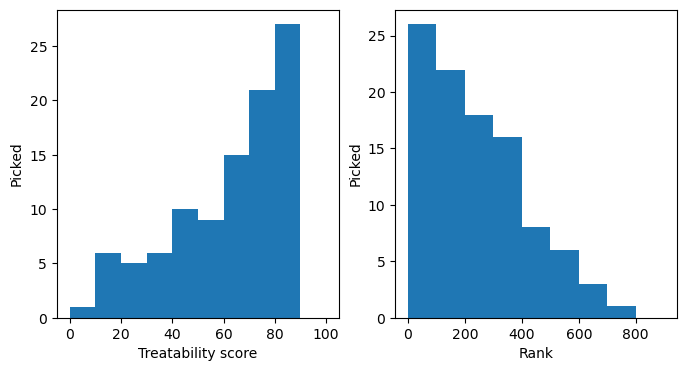

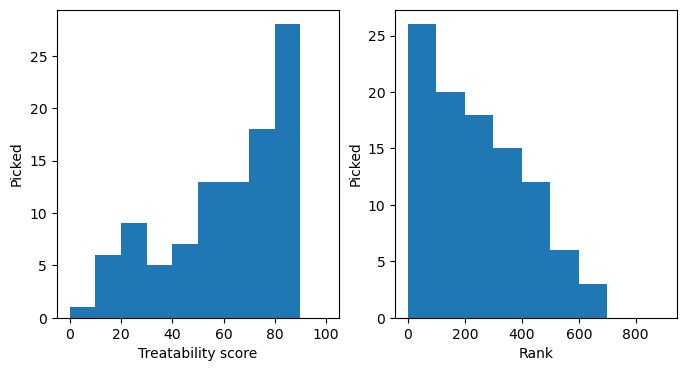

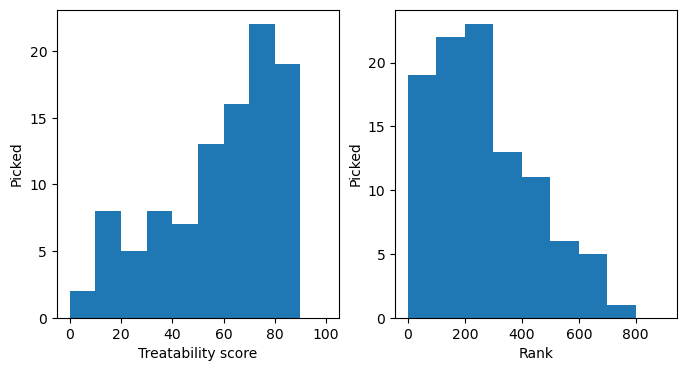

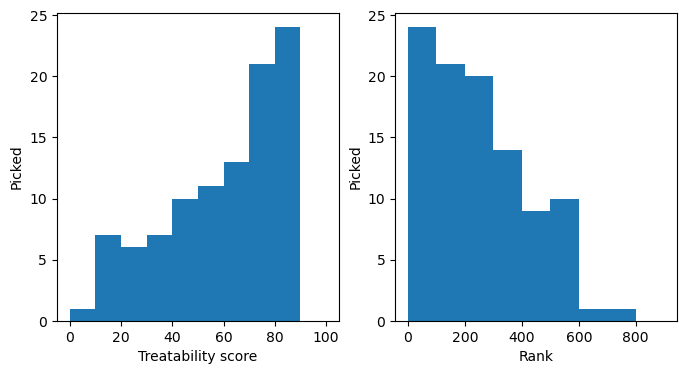

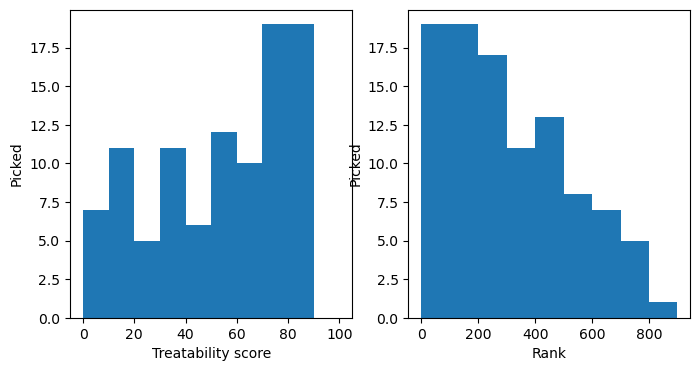

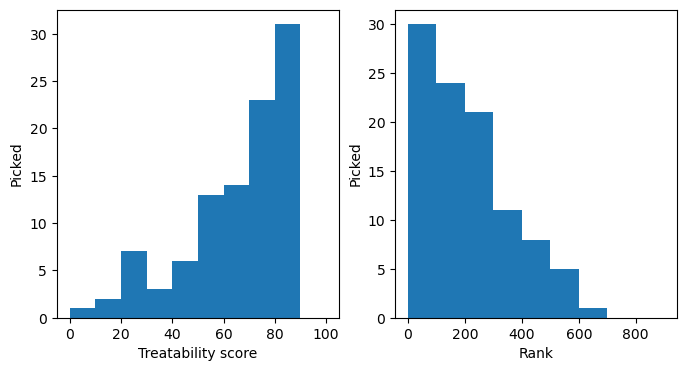

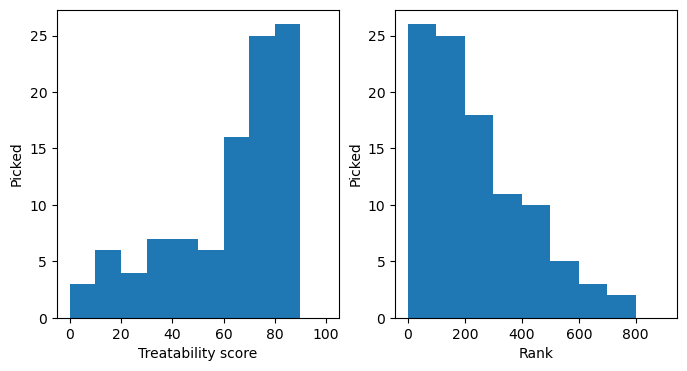

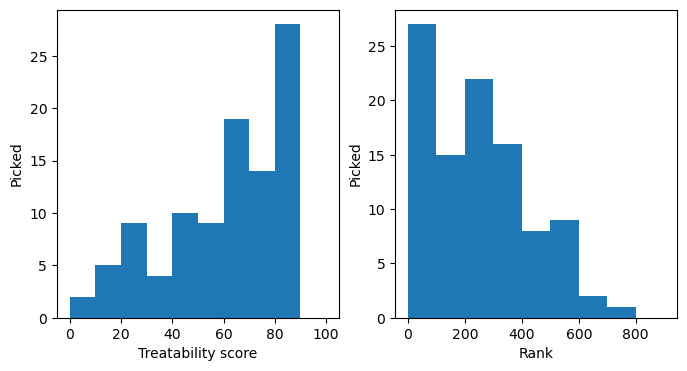

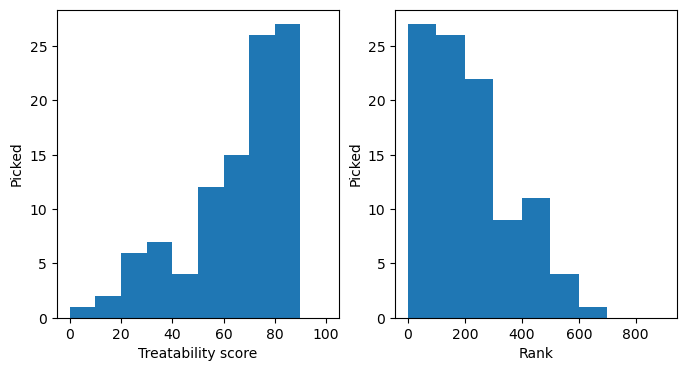

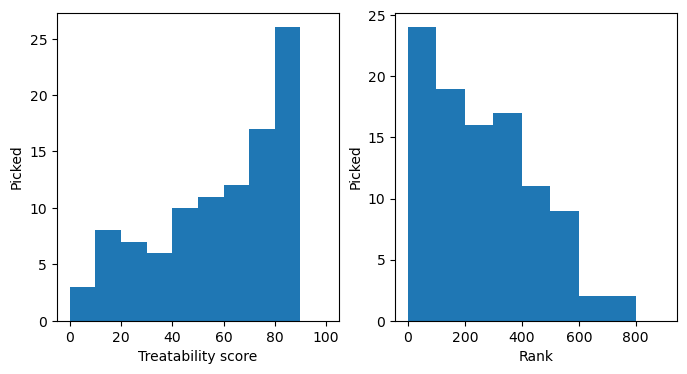

In [357]:
np.random.seed(42)

for t in range(n_trials):
    picked_patients = np.random.choice(
        inds, size=n_picked, replace=False, p=df_treatability['relative_chance'])

    picked_bool = np.full(inds.shape, 0)
    picked_bool[picked_patients] = 1

    treatability_hist_bins = np.arange(0.0, 100.1, 10)
    rank_hist_bins = np.arange(0, n_subset, 0.1*n_subset)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    # axs[0].scatter(modelled_treatability_percs, picked_bool, alpha=0.1)
    # axs[1].scatter(ranked_modelled_treatability_relative_chance, picked_bool, alpha=0.1)

    axs[0].hist(df_treatability['modelled_treatability_%'][picked_bool == 1], bins=treatability_hist_bins)
    axs[1].hist(df_treatability['rank'][picked_bool == 1], bins=rank_hist_bins)

    axs[0].set_xlabel('Treatability score')
    axs[0].set_ylabel('Picked')
    axs[1].set_xlabel('Rank')
    axs[1].set_ylabel('Picked')
    plt.show()
    plt.close()